In [83]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pandas as pd
import seaborn as sns
import librosa as lbr

import warnings
warnings.filterwarnings('ignore')

## Препроцессинг

In [2]:
data = pd.read_csv('speakers_all.csv', usecols=['age', 'age_onset', 'birthplace', 'native_language',
                                                'sex', 'speakerid', 'country', 'filename'])

In [3]:
data.head(5)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti


Оставим только родные языки с количеством вхождений > 30

In [4]:
temp = data[['speakerid', 'native_language']].groupby(by='native_language').count()
native_languages = temp[temp['speakerid'] > 30].index

In [5]:
native_languages

Index(['arabic', 'dutch', 'english', 'french', 'german', 'italian', 'korean',
       'mandarin', 'polish', 'portuguese', 'russian', 'spanish', 'turkish'],
      dtype='object', name='native_language')

In [6]:
data = data[data['native_language'].isin(native_languages)]

In [7]:
data

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
70,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,11,saudi arabia
71,26.0,5.0,"cairo, egypt",arabic10,arabic,male,12,egypt
72,40.0,10.0,"beirut, lebanon",arabic100,arabic,female,2159,lebanon
73,21.0,10.0,"doha, qatar",arabic101,arabic,male,2160,qatar
74,22.0,3.0,"jiddah, saudi arabia",arabic102,arabic,male,2161,saudi arabia
...,...,...,...,...,...,...,...,...
2075,30.0,11.0,"istanbul, turkey",turkish5,turkish,female,385,turkey
2076,19.0,14.0,"istanbul, turkey",turkish6,turkish,male,386,turkey
2077,19.0,13.0,"izmir, turkey",turkish7,turkish,male,387,turkey
2078,37.0,17.0,"sivas, turkey",turkish8,turkish,male,478,turkey


Добавим в датафрейм столбец с информацией о zero_crossing

In [ ]:
from tqdm.notebook import tqdm

zero_crossings = []
for filename in tqdm(data['filename'].values):
    x, _ = lbr.load(f'recordings/recordings/{filename}.mp3')
    zero_crossings.append(sum(lbr.zero_crossings(x, pad=False)))

In [ ]:
data['zero_crossing'] = zero_crossings

In [ ]:
data.to_csv('with_zc.csv', index=False)

In [17]:
data = pd.read_csv('with_zc.csv')

In [18]:
data

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,zero_crossing
0,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,11,saudi arabia,99051
1,26.0,5.0,"cairo, egypt",arabic10,arabic,male,12,egypt,90522
2,40.0,10.0,"beirut, lebanon",arabic100,arabic,female,2159,lebanon,116514
3,21.0,10.0,"doha, qatar",arabic101,arabic,male,2160,qatar,103941
4,22.0,3.0,"jiddah, saudi arabia",arabic102,arabic,male,2161,saudi arabia,58208
...,...,...,...,...,...,...,...,...,...
1301,30.0,11.0,"istanbul, turkey",turkish5,turkish,female,385,turkey,63750
1302,19.0,14.0,"istanbul, turkey",turkish6,turkish,male,386,turkey,42213
1303,19.0,13.0,"izmir, turkey",turkish7,turkish,male,387,turkey,82867
1304,37.0,17.0,"sivas, turkey",turkish8,turkish,male,478,turkey,93147


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78d4ebbac8>]],
      dtype=object)

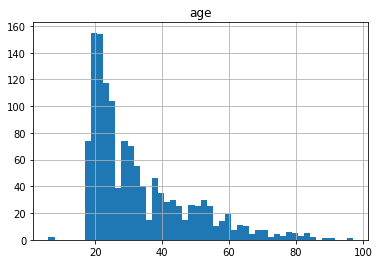

In [19]:
data.hist('age', bins=50)

Избавимся от выбросов в левой части гистограммы.

In [20]:
data = data[data['age'] > 10]

Разобьем датасет на 3 категории по возрасту young(15-24), middle-age(25-39), old(40+)

In [21]:
cat_age = []
for age in data['age']:
    if age <= 24:
        cat_age.append('young')
    elif age <= 39:
        cat_age.append('middle-aged')
    else:
        cat_age.append('old')

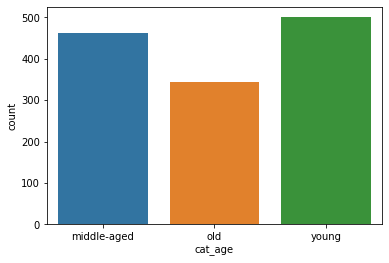

In [22]:
data['cat_age'] = cat_age
sns.countplot('cat_age', data=data);

### Трехфакторный дисперсионный анализ

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [24]:
lm = ols('zero_crossing ~ C(cat_age) * C(native_language) * C(sex)', data=data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(cat_age),2.0,2.129793e+10,1.064897e+10,13.096626,2.355413e-06
C(native_language),12.0,1.296855e+11,1.080713e+10,13.291143,4.383335e-26
C(sex),1.0,1.919855e+10,1.919855e+10,23.611329,1.331259e-06
C(cat_age):C(native_language),24.0,3.847478e+10,1.603116e+09,1.971591,3.500945e-03
C(cat_age):C(sex),2.0,4.939872e+08,2.469936e+08,0.303765,7.380898e-01
C(native_language):C(sex),12.0,6.995392e+09,5.829494e+08,0.716940,7.359856e-01
C(cat_age):C(native_language):C(sex),24.0,1.479922e+10,6.166341e+08,0.758367,7.917787e-01
Residual,1227.0,9.976830e+11,8.131076e+08,NaN,NaN


Значимые взаимодействия в нашем случае

In [25]:
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(cat_age),2.0,2.129793e+10,1.064897e+10,13.096626,2.355413e-06
C(native_language),12.0,1.296855e+11,1.080713e+10,13.291143,4.383335e-26
C(sex),1.0,1.919855e+10,1.919855e+10,23.611329,1.331259e-06
C(cat_age):C(native_language),24.0,3.847478e+10,1.603116e+09,1.971591,3.500945e-03


Есть значимое межфакторное взаимодействие. Попробуем произвести двухфакторный анализ для каждого из родных языков в отдельности

In [38]:
for lang in native_languages:
    lm = ols('zero_crossing ~ C(cat_age) * C(sex)', 
             data=data[data['native_language'] == lang]).fit()
    table = sm.stats.anova_lm(lm, typ=1)
    print('-' * 80)
    print(f'{lang} language')
    print(table)

--------------------------------------------------------------------------------
arabic language
                     df        sum_sq       mean_sq         F    PR(>F)
C(cat_age)          2.0  1.771646e+10  8.858231e+09  4.649793  0.011818
C(sex)              1.0  2.415313e+09  2.415313e+09  1.267827  0.262982
C(cat_age):C(sex)   2.0  1.331129e+09  6.655645e+08  0.349363  0.706030
Residual           96.0  1.828877e+11  1.905081e+09       NaN       NaN
--------------------------------------------------------------------------------
dutch language
                     df        sum_sq       mean_sq         F    PR(>F)
C(cat_age)          2.0  5.704160e+09  2.852080e+09  2.785059  0.073429
C(sex)              1.0  4.592154e+07  4.592154e+07  0.044842  0.833343
C(cat_age):C(sex)   2.0  1.292688e+09  6.463439e+08  0.631155  0.537066
Residual           41.0  4.198664e+10  1.024064e+09       NaN       NaN
--------------------------------------------------------------------------------
englis

Как видно из вышеприведенных таблиц, возраст является значимым признаком для родных арабского, нидерландского, английского, корейского, русского и испанского языков. Пол - для английского, французского и немецкого. А межфакторное взаимодействие имеет достаточную значимость только для мандаринского китайского.

#### Визуализация

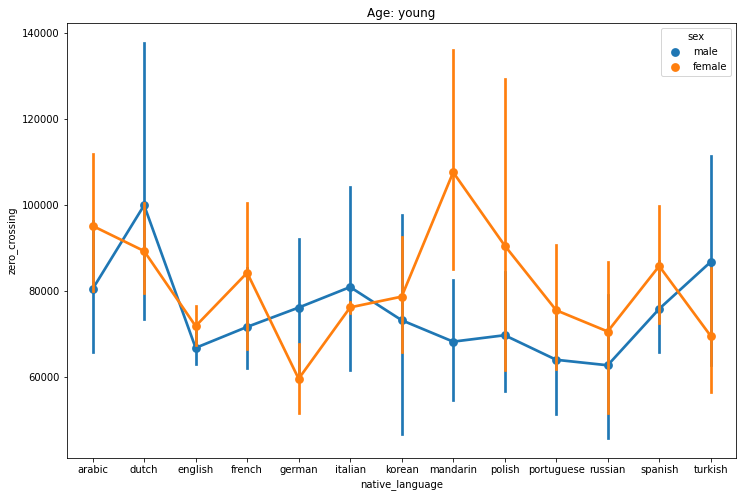

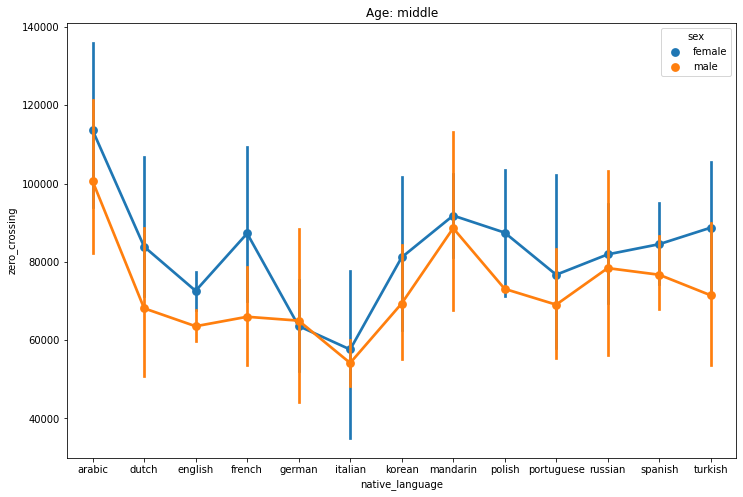

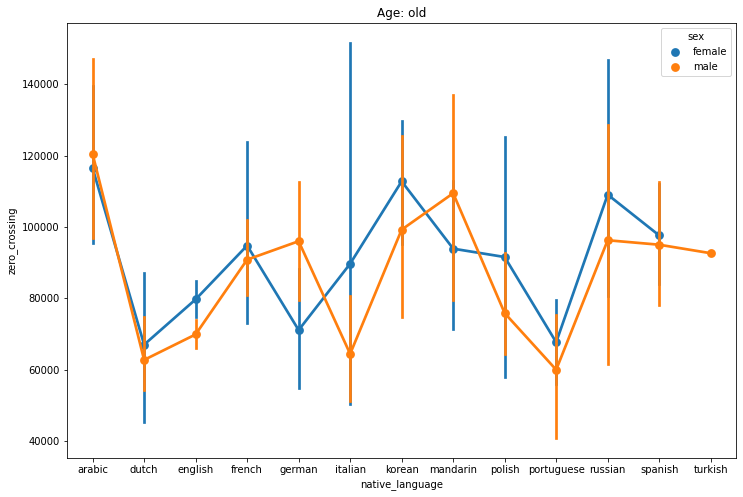

In [35]:
plt.figure(figsize=(12, 8))
plt.title('Age: young')
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['cat_age'] == 'young'], hue='sex')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Age: middle')
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['cat_age'] == 'middle-aged'], hue='sex')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Age: old')
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['cat_age'] == 'old'], hue='sex')
plt.show()

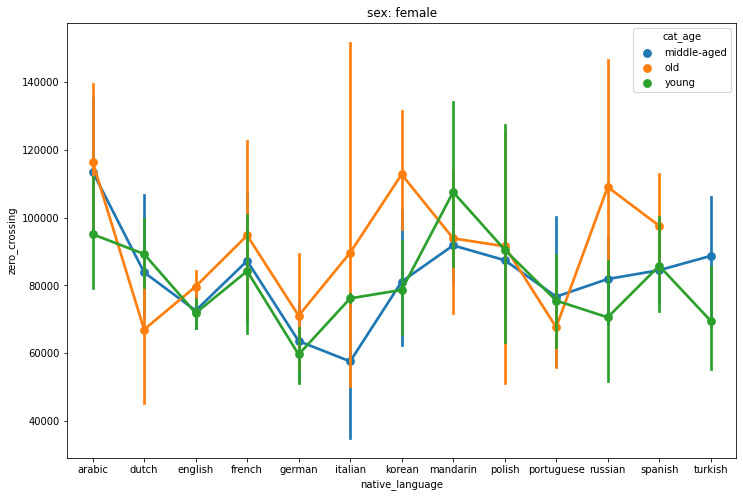

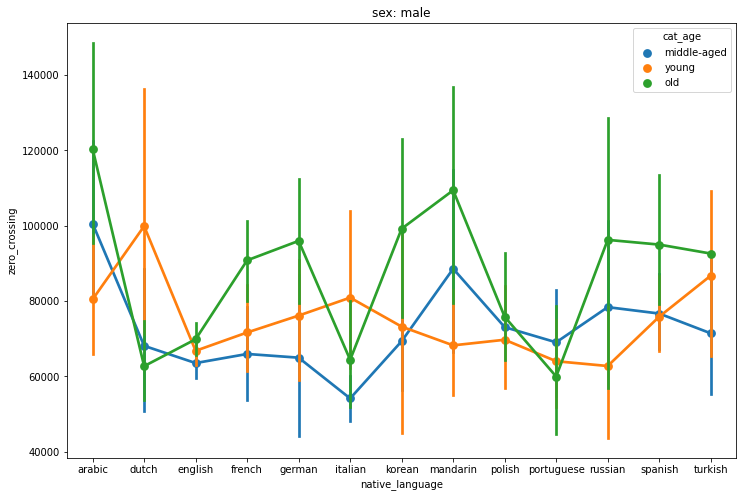

In [36]:
plt.figure(figsize=(12, 8))
plt.title('sex: female')
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['sex'] == 'female'], hue='cat_age')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('sex: male')
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['sex'] == 'male'], hue='cat_age')
plt.show()

Разделим выборку по возрастному признаку и проведем двухфакторный анализ

### Двухфакторный анализ для молодых людей

In [34]:
lm = ols('zero_crossing ~ C(native_language) * C(sex)', data=data[data['cat_age'] == 'young']).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),12.0,2.902029e+10,2.418357e+09,3.236159,0.000171
C(sex),1.0,4.507258e+09,4.507258e+09,6.031451,0.014411
C(native_language):C(sex),12.0,1.342430e+10,1.118692e+09,1.496994,0.121366
Residual,474.0,3.542166e+11,7.472924e+08,NaN,NaN


Значимы оба признака и их межфакторное взаимодействие


#### Визуализация

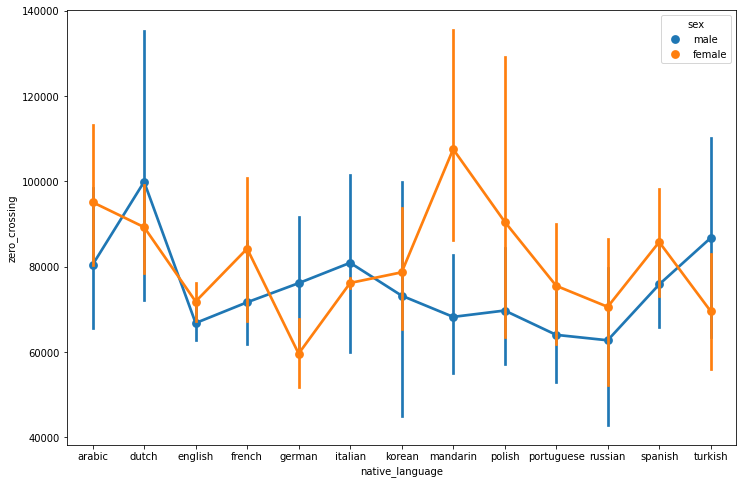

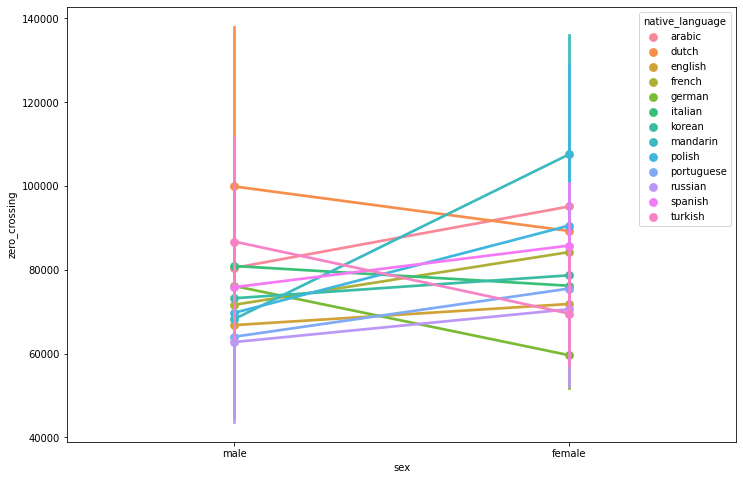

In [39]:
plt.figure(figsize=(12, 8))
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['cat_age'] == 'young'], hue='sex')
plt.show()

plt.figure(figsize=(12, 8))
_ = sns.pointplot(x="sex", y="zero_crossing", data=data[data['cat_age'] == 'young'], hue='native_language')
plt.show()

Снова поделим выборку

#### Однофакторный анализ для молодых женщин

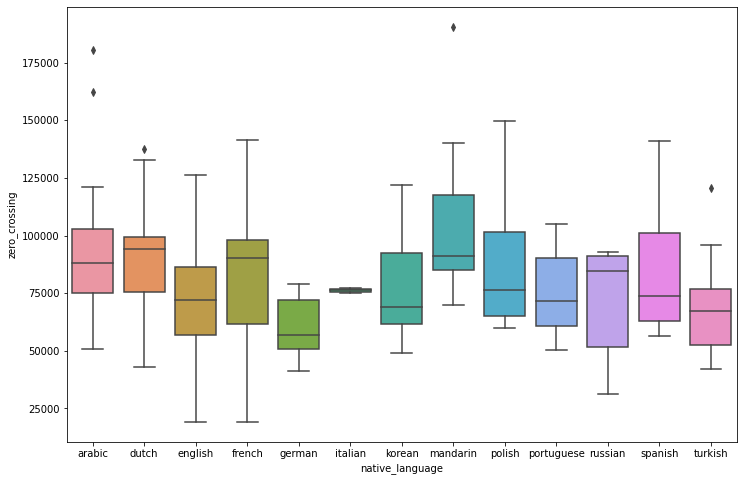

In [44]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='native_language', y='zero_crossing', data=data[(data['cat_age'] == 'young') & 
                                                         (data['sex'] == 'female')])

In [42]:
lm = ols('zero_crossing ~ C(native_language)', data=data[(data['cat_age'] == 'young') & 
                                                         (data['sex'] == 'female')]).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),12.0,2.466575e+10,2.055479e+09,3.054497,0.000546
Residual,211.0,1.419894e+11,6.729354e+08,NaN,NaN


#### Однофакторный анализ для молодых мужчин

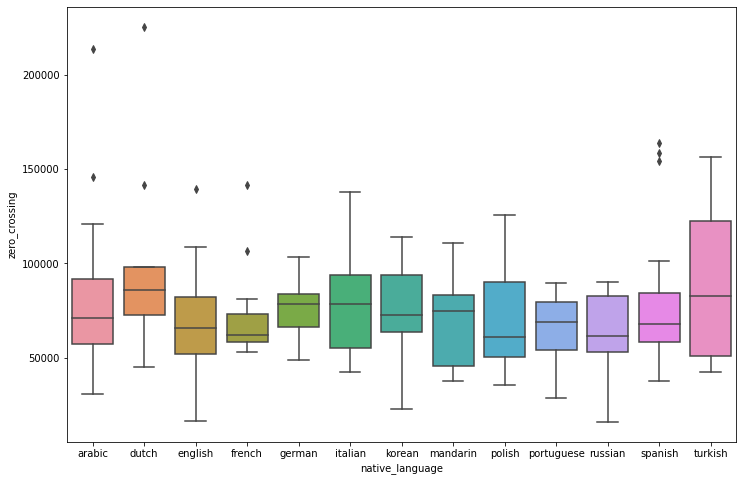

In [46]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='native_language', y='zero_crossing', data=data[(data['cat_age'] == 'young') & 
                                                         (data['sex'] == 'male')])

In [50]:
lm = ols('zero_crossing ~ C(native_language)', data=data[(data['cat_age'] == 'young') & 
                                                         (data['sex'] == 'male')]).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),12.0,1.720666e+10,1.433888e+09,1.776929,0.052039
Residual,263.0,2.122273e+11,8.069477e+08,NaN,NaN


In [53]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(
    data[(data['cat_age'] == 'young') & (data['sex'] == 'male')]['zero_crossing'], 
    data[(data['cat_age'] == 'young') & (data['sex'] == 'male')]['native_language'])
result = mc.tukeyhsd()
print(result)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1     group2     meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------
    arabic      dutch  19442.0694 0.8598 -17683.7389 56567.8778  False
    arabic    english -13665.9583 0.6058 -34847.6293  7515.7127  False
    arabic     french  -8797.0417    0.9   -40059.77 22465.6867  False
    arabic     german  -4315.3083    0.9 -51008.5687 42377.9521  False
    arabic    italian    455.1667    0.9 -38321.4755 39231.8088  False
    arabic     korean  -7246.1083    0.9 -53939.3687 39447.1521  False
    arabic   mandarin -12220.2083    0.9  -47970.506 23530.0893  False
    arabic     polish -10732.3512    0.9 -42674.7836 21210.0812  False
    arabic portuguese -16432.6174    0.9 -51016.8293 18151.5944  False
    arabic    russian -17704.8512    0.9 -58505.9661 23096.2637  False
    arabic    spanish  -4609.7083    0.9 -30090.9544 20871.5377  False
    ar

In [54]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(
    data[(data['cat_age'] == 'young') & (data['sex'] == 'female')]['zero_crossing'], 
    data[(data['cat_age'] == 'young') & (data['sex'] == 'female')]['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1     group2     meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------
    arabic      dutch  -5844.9107    0.9 -34693.8573  23004.0359  False
    arabic    english -23269.6556 0.0538 -46710.7635    171.4523  False
    arabic     french -10885.2404    0.9 -43346.5524  21576.0716  False
    arabic     german  -35486.925 0.0441  -70531.873    -441.977   True
    arabic    italian  -18920.625    0.9 -84122.4873  46281.2373  False
    arabic     korean -16427.7083    0.9 -49626.8716  16771.4549  False
    arabic   mandarin    12439.25    0.9 -25205.0628  50083.5628  False
    arabic     polish   -4567.625    0.9 -53166.2238  44030.9738  False
    arabic portuguese -19587.0536    0.9  -58983.191  19809.0838  False
    arabic    russian -24520.0536 0.6504  -63916.191  14876.0838  False
    arabic    spanish     -9326.5    0.9 -40062.9527  21409.9527

Можно сказать, что с у датских молодых мужчин сумма zero_crossing сильно меньше этого показателя у английских (с уровнем значимости 0.15). 

У арабских молодых женщин ниже, чем у английских и немецких, у голландских ниже, чем у немецких, у английских выше, чем у китайских и у китайских ниже, чем у турецких.

### Двухфакторный анализ для людей среднего возраста

In [56]:
lm = ols('zero_crossing ~ C(native_language) * C(sex)', data=data[data['cat_age'] == 'middle-aged']).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),12.0,6.417135e+10,5.347613e+09,6.526275,9.446240e-11
C(sex),1.0,9.088682e+09,9.088682e+09,11.091911,9.409494e-04
C(native_language):C(sex),12.0,2.164659e+09,1.803883e+08,0.220147,9.974872e-01
Residual,435.0,3.564378e+11,8.193973e+08,NaN,NaN


Оба признака значимы, а их взаимодействие - нет

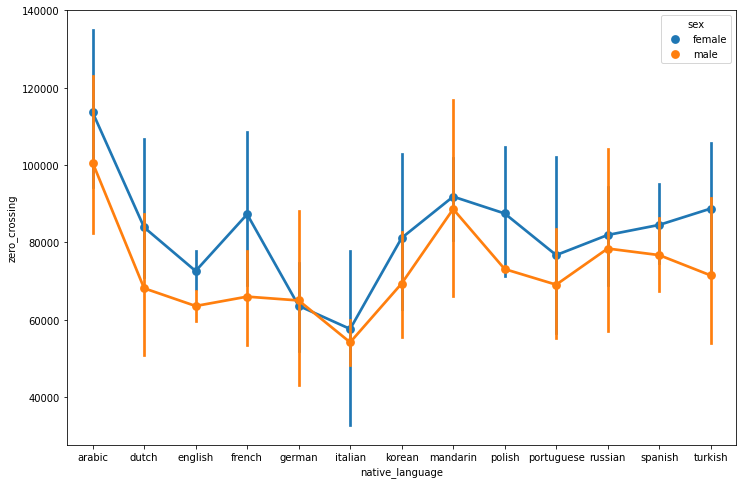

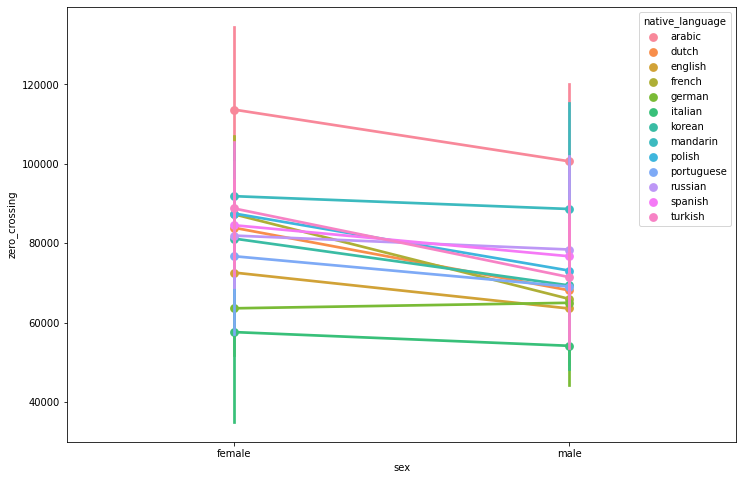

In [57]:
plt.figure(figsize=(12, 8))
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['cat_age'] == 'middle-aged'], hue='sex')
plt.show()

plt.figure(figsize=(12, 8))
_ = sns.pointplot(x="sex", y="zero_crossing", data=data[data['cat_age'] == 'middle-aged'], hue='native_language')
plt.show()

Исследуем попарные различия в зависимости от пола и родного языка

In [74]:
mc = MultiComparison(
    data[data['cat_age'] == 'middle-aged']['zero_crossing'], 
    data[data['cat_age'] == 'middle-aged']['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1     group2     meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------
    arabic      dutch -32348.0579 0.0791 -66263.3642   1567.2484  False
    arabic    english -38977.0814  0.001 -55988.7031 -21965.4597   True
    arabic     french -31224.1579 0.0061 -57585.9011  -4862.4147   True
    arabic     german -42431.5425  0.001 -73092.6994 -11770.3856   True
    arabic    italian -50700.4912  0.001 -86076.0086 -15324.9739   True
    arabic     korean -33072.7895 0.0032 -59885.1934  -6260.3856   True
    arabic   mandarin -16078.4011  0.429 -38118.0614   5961.2591  False
    arabic     polish -20904.1579 0.7243 -56279.6752  14471.3594  False
    arabic portuguese -34239.2033  0.001 -59803.8274  -8674.5793   True
    arabic    russian -26238.8101 0.0327 -51449.0004  -1028.6197   True
    arabic    spanish -27094.8722  0.001 -46695.2994   -7494.445

У арабских людей среднего возраста параметр суммы zero_crossing значимо ниже, чем у всех остальных, кроме китайских, у английских и итальянских выше, чем у китайских.

In [75]:
mc = MultiComparison(
    data[data['cat_age'] == 'middle-aged']['zero_crossing'], 
    data[data['cat_age'] == 'middle-aged']['sex'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
female   male -9792.3474 0.001 -15342.0152 -4242.6797   True
------------------------------------------------------------


У женщин среднего возраста значимо ниже, чем у мужчин

### Двухфакторный анализ для пожилых людей

In [65]:
lm = ols('zero_crossing ~ C(native_language) * C(sex)', data=data[data['cat_age'] == 'old']).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),12.0,7.704714e+10,6.420595e+09,7.113402,1.694511e-11
C(sex),1.0,4.018139e+09,4.018139e+09,4.451711,3.564722e-02
C(native_language):C(sex),12.0,5.534525e+09,4.612105e+08,0.510977,9.073587e-01
Residual,318.0,2.870285e+11,9.026054e+08,NaN,NaN


Оба признака значимы, а их взаимодействие - нет.

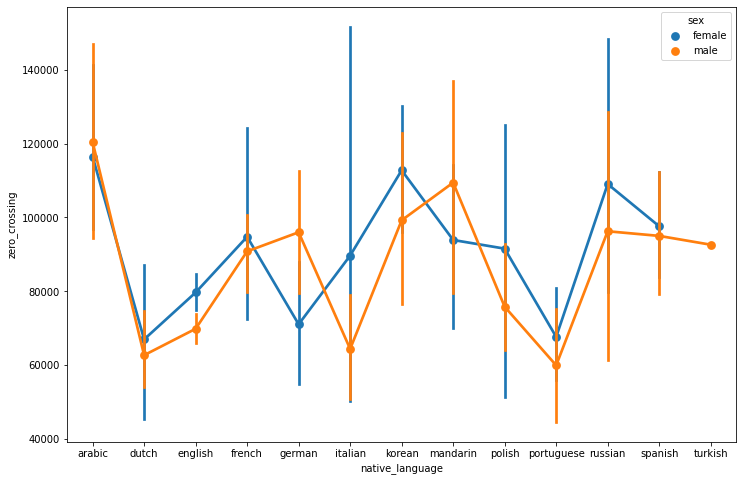

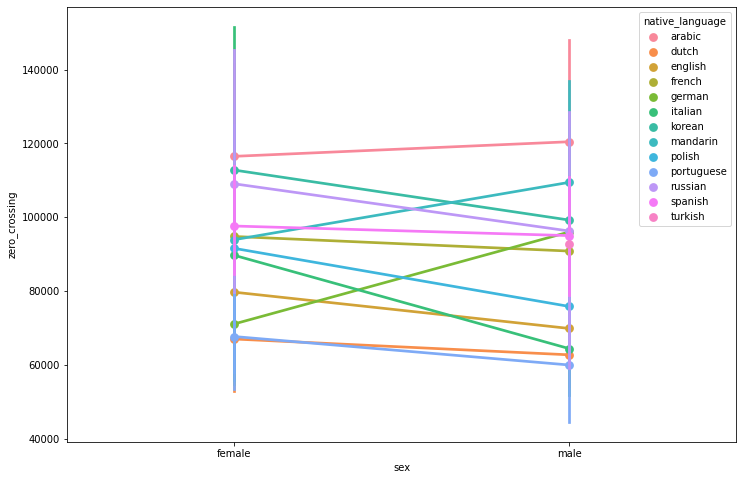

In [66]:
plt.figure(figsize=(12, 8))
_ = sns.pointplot(x="native_language", y="zero_crossing", data=data[data['cat_age'] == 'old'], hue='sex')
plt.show()

plt.figure(figsize=(12, 8))
_ = sns.pointplot(x="sex", y="zero_crossing", data=data[data['cat_age'] == 'old'], hue='native_language')
plt.show()

In [80]:
mc = MultiComparison(
    data[data['cat_age'] == 'old']['zero_crossing'], 
    data[data['cat_age'] == 'old']['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
    arabic      dutch -54572.1667  0.002  -97514.5045 -11629.8288   True
    arabic    english -44403.7888  0.001  -66186.7877 -22620.7898   True
    arabic     french -25928.0333 0.2972  -58831.4147   6975.3481  False
    arabic     german -41813.5417 0.0389  -82625.1635  -1001.9199   True
    arabic    italian -49303.1667  0.001  -82921.9226 -15684.4107   True
    arabic     korean -12278.0417    0.9  -44542.4616  19986.3783  False
    arabic   mandarin -20562.6667 0.8147  -58189.1228  17063.7895  False
    arabic     polish  -34304.881 0.2764  -77247.2188   8637.4569  False
    arabic portuguese -55305.6667  0.001  -96117.2885 -14494.0449   True
    arabic    russian  -15887.803    0.9  -52286.9778  20511.3717  False
    arabic    spanish -22657.7867 0.1143  -47482.52

У арабских пожилых людей сумма zero_crossing значимо ниже всех, кроме французских, китайских и португальских, у голландских, итальянских, португальских и английских выше, чем у корейских, у английских выше, чем у испанских и русских, у итальянских, чем у испанских.

In [81]:
mc = MultiComparison(
    data[data['cat_age'] == 'old']['zero_crossing'], 
    data[data['cat_age'] == 'old']['sex'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj     lower     upper   reject
-----------------------------------------------------------
female   male -7061.1422 0.0476 -14047.1492 -75.1351   True
-----------------------------------------------------------


У пожилых женщин сумма zero_crossing значимо ниже, чем у мужчин

На самом деле в трехфакторном анализе пол не учавствовал ни в каком значимом межфакторном взаимодействии, поэтому можно сравнить эффект пола на всей выборке.

In [82]:
mc = MultiComparison(
    data['zero_crossing'], 
    data['sex'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
female   male -8083.0733 0.001 -11395.5537 -4770.5928   True
------------------------------------------------------------


Видим, что сумма zero_crossing значимо ниже в среднем на 8к у женщин, чем у мужчин